In [155]:
import numpy as np
import os
from scipy import linalg
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
#from matplotlib import patches
%matplotlib inline

In [2]:
mat_path = "../output/BOSS_DR12_NGC_z1/matrices/"

In [39]:
def retrieve_single_param(path):
    params = []
    
    fnames = [f for f in os.listdir(path) if not f.startswith('.')]
    for fname in fnames:
        with open(os.path.join(path, fname)) as f:
            first_line = f.readline().strip('\n')
        val = float(first_line.split("=")[1])
        params.append(val)
    
    return np.array(params)

Number shrinkage intensities equal to 1 (empirical target): 31
Number shrinkage intensities equal to 1 (empirical target): 21


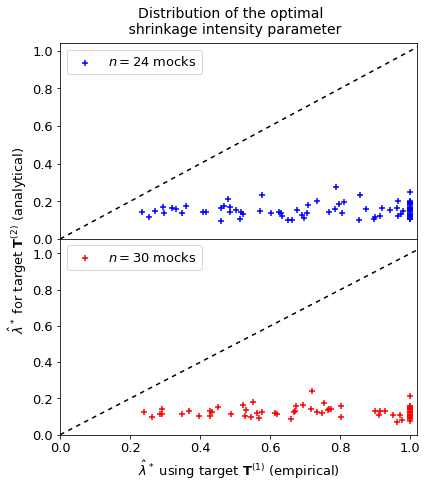

In [85]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(6.4, 7.2)

xs = ys = np.linspace(0, 1.1, 100)

nsamples = [24, 30]
colors = ["blue", "red"]
for i, n in enumerate(nsamples):
    la_emp = retrieve_single_param(os.path.join(mat_path, f"n{n}", "cov_shrinkage_emp"))
    la_ana = retrieve_single_param(os.path.join(mat_path, f"n{n}", "cov_shrinkage_ana"))
    
    print("Number shrinkage intensities equal to 1 (empirical target):", np.sum(la_emp==1))
    
    axs[i].scatter(la_emp, la_ana, c=colors[i], marker="+", label=f"$n={n}$ mocks")
    axs[i].plot(xs, ys, ls="-", dashes=(3,3), c="black")
    axs[i].legend(fontsize=13)
    axs[i].set_xlim([0.0, 1.02])
    axs[i].tick_params(axis='both', which='major', labelsize=13)

axs[0].set_ylim([0.0, 1.04])
axs[1].set_ylim([0.0, 1.08])
axs[1].set_xlabel(r"$\hat{\lambda}^*$ using target $\mathbf{T}^{(1)}$ (empirical)", fontsize=13)

fig.supylabel(r"$\hat{\lambda}^*$ for target $\mathbf{T}^{(2)}$ (analytical)", fontsize=13, x=0.01)
fig.suptitle("Distribution of the optimal \n shrinkage intensity parameter", fontsize=14, y=0.95)

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/optimal-intensity.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

n=24 mocks, min  0.5  and max 0.875
n=30 mocks, min  0.6333333333333333  and max 0.8666666666666667


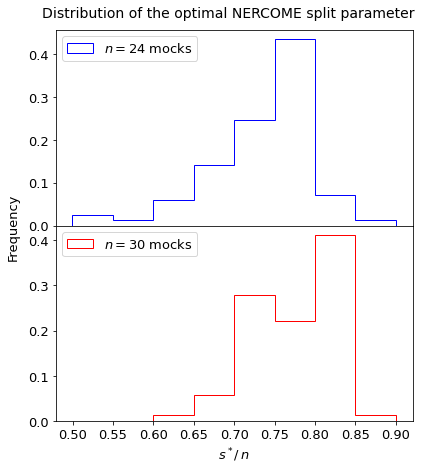

In [38]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(6.4, 7.2)

bins=np.linspace(0.5, 0.9, 9)
bins[0] -= 0.001
bins[-1] += 0.001

nsamples = [24, 30]
colors = ["blue", "red"]
for i, n in enumerate(nsamples):
    s_opt = retrieve_single_param(os.path.join(mat_path, f"n{n}", "cov_NERCOME"))
    print(f"n={n} mocks, min ", np.min(s_opt/n), " and max", np.max(s_opt/n))
    
    axs[i].hist(s_opt/n, bins=bins, color=colors[i], histtype="step", label=f"$n={n}$ mocks", weights=np.ones_like(s_opt) / len(s_opt))
    axs[i].legend(loc="upper left", fontsize=13)
    axs[i].tick_params(axis='both', which='major', labelsize=13)


axs[1].set_xlabel(r"$s^* /\, n$", fontsize=13)
fig.supylabel("Frequency", fontsize=13)

fig.suptitle(r"Distribution of the optimal NERCOME split parameter", fontsize=14, y=0.925)

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/optimal-split.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [127]:
def retrieve_double_param(path):
    params = []
    
    fnames = [f for f in os.listdir(path) if not f.startswith('.')]
    for fname in fnames:
        with open(os.path.join(path, fname)) as f:
            first_line = f.readline().strip('\n')
        parts = first_line.split(",")
        alpha = float(parts[0].split("=")[1])
        beta = float(parts[1].split("=")[1])
        params.append([alpha, beta])
        
    return np.array(params)

pre_shrinkage_emp 24 # negative alpha values 0
pre_shrinkage_emp 30 # negative alpha values 0
pre_shrinkage_ana 24 # negative alpha values 1
pre_shrinkage_ana 30 # negative alpha values 0


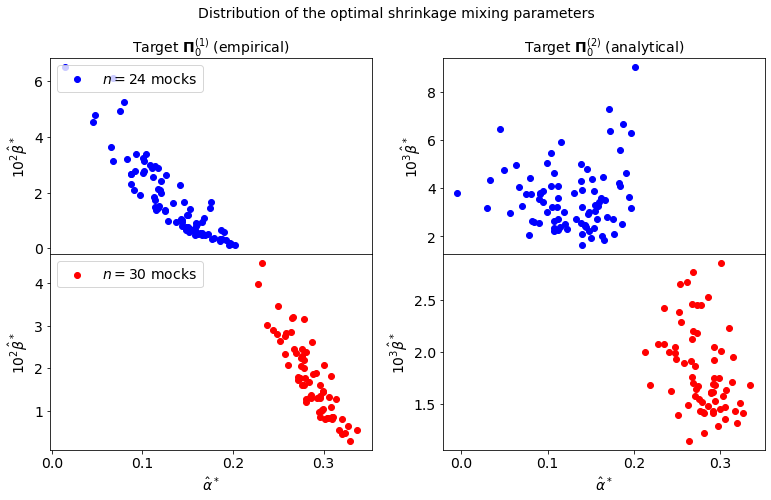

In [128]:
nsamples = [24, 30]
colors = ["blue", "red"]
est_types = ["pre_shrinkage_emp", "pre_shrinkage_ana"]
labels = ["Target $\mathbf{\Pi}_0^{(1)}$ (empirical)", "Target $\mathbf{\Pi}_0^{(2)}$ (analytical)"]

fig, axs = plt.subplots(2, 2, sharex="col")
fig.subplots_adjust(hspace=0, wspace=0.22)
fig.set_size_inches(12.8, 7.2)

for k, est_type in enumerate(est_types):
    
    for i,n in enumerate(nsamples):
        alpha, beta = retrieve_double_param(os.path.join(mat_path, f"n{n}", est_type)).T
        
        print(est_type, n, "# negative alpha values", np.sum(alpha < 0))
        
        if k == 0:
            mult = 2
        if k == 1:
            mult = 3
        
        axs[i,k].scatter(alpha, beta*(10**mult), c=colors[i], label=f"$n={n}$ mocks")
        axs[i,k].set_ylabel(r"$10^{%d}\hat{\beta}^*$" % mult, fontsize=14)
        axs[i,k].tick_params(axis='both', which='major', labelsize=14)
        #axs[i,k].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[i,0].legend(fontsize=14, loc="upper left")
    
    axs[0,k].set_title(labels[k], fontsize=14)
    axs[1,k].set_xlabel(r"$\hat{\alpha}^*$", fontsize=14)

fig.suptitle(r"Distribution of the optimal shrinkage mixing parameters", fontsize=14)
#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/optimal-mixing.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
plt.show()

In [89]:
def hartlap(n, p=18):
    return (n-p-2)/(n-1)

In [156]:
def norm(M):
    return np.sqrt(np.abs(np.trace(M @ M.T)))

def loss(est, C_ref):
    p = est.shape[0]
    Id = np.identity(p)
    
    return norm(linalg.sqrtm(est) @ C_ref / hartlap(2048) @ linalg.sqrtm(est) - Id)

n=24 mocks
cov sample 6.8 2.2 7.4
cov shrinkage_emp 2.4 0.3 1.0
cov shrinkage_ana 38.3 10.5 25.2
cov NERCOME 3.6 0.5 1.2
pre shrinkage_emp 7.2 2.3 7.8
pre shrinkage_ana 6.6 3.0 8.5


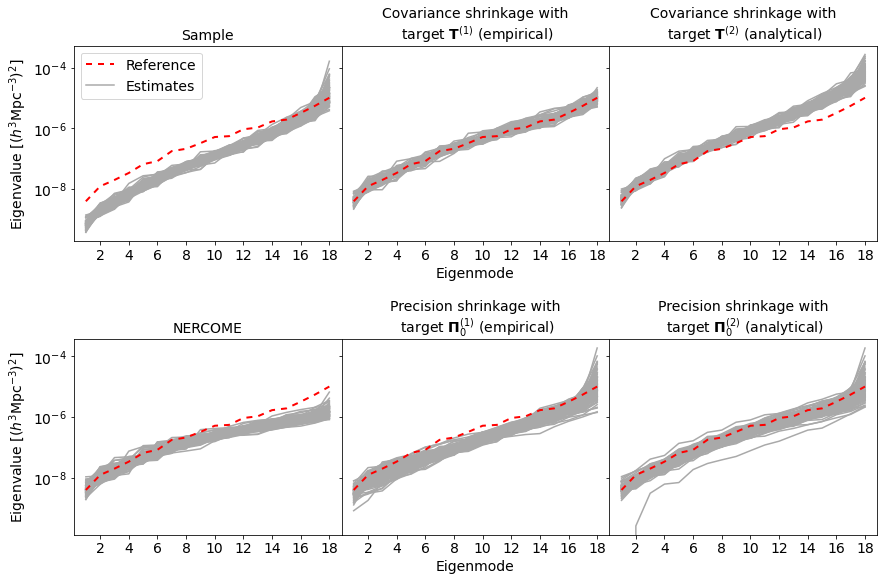

n=30 mocks
cov sample 5.4 1.2 1.8
cov shrinkage_emp 2.3 0.3 0.6
cov shrinkage_ana 18.7 4.3 5.3
cov NERCOME 3.3 0.4 0.5
pre shrinkage_emp 5.8 1.6 2.2
pre shrinkage_ana 4.7 1.1 1.7


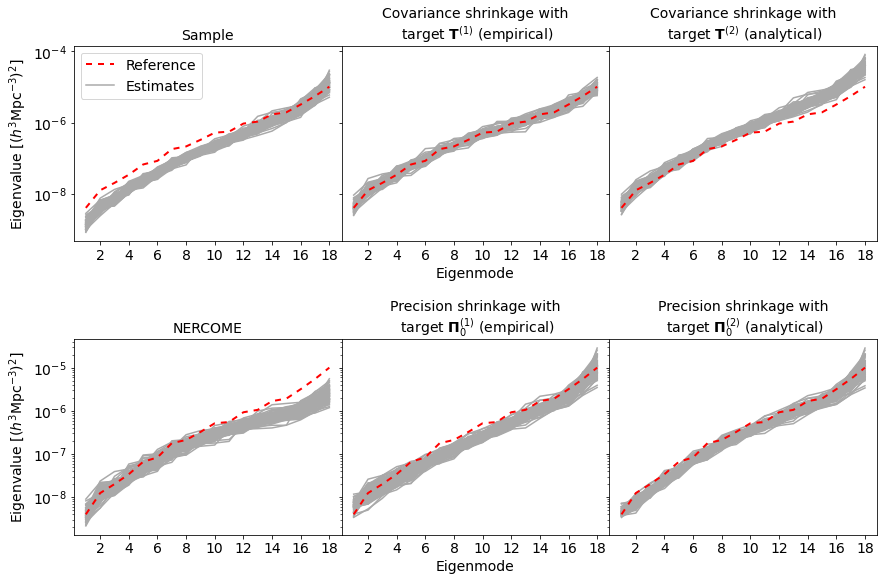

In [161]:
nsamples = [24, 30]
estimates = [
    ["cov", "sample", "Sample"],
    ["cov", "shrinkage_emp", "Covariance shrinkage with\n target $\mathbf{T}^{(1)}$ (empirical)"],
    ["cov", "shrinkage_ana", "Covariance shrinkage with\n target $\mathbf{T}^{(2)}$ (analytical)"],
    ["cov", "NERCOME", "NERCOME"],
    ["pre", "shrinkage_emp", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["pre", "shrinkage_ana", "Precision shrinkage with\n target $\mathbf{\Pi}_0^{(2)}$ (analytical)"],
]

emodes = np.linspace(1, 18, 18)
xticks = np.linspace(2, 18, 9)

C_ref = np.loadtxt(os.path.join(mat_path, "n2048/cov_sample/cov_18_18_sample_2048_v1.matrix"))
Psi_ref = np.linalg.inv(C_ref) * hartlap(2048)
evals_ref = np.linalg.eigvalsh(Psi_ref)

for n in nsamples:
    print(f"n={n} mocks")
    
    fig, axs = plt.subplots(2, 3, sharey="row")
    fig.subplots_adjust(wspace=0, hspace=0.5)
    fig.set_size_inches(14.4, 9)
    
    for k, estimate in enumerate(estimates):
        mat_type = estimate[0]
        est_type = estimate[1]
        plt_title = estimate[2]
        
        i = k//3
        j = k % 3
        
        axs[i,j].plot(emodes, evals_ref, c="red", ls="-", dashes=(3,3), linewidth=2, zorder=10, label="Reference")
        
        losses = []
        
        data_path = os.path.join(mat_path, f"n{n}/{mat_type}_{est_type}/")
        fnames = [f for f in os.listdir(data_path) if not f.startswith('.')]
        for fname in fnames:
            matrix = np.loadtxt(os.path.join(data_path, fname))
            
            if mat_type == "cov":
                # Obtain precision matrix
                Psi = np.linalg.inv(matrix)
                if est_type == "sample":
                    # Apply Hartlap correction
                    Psi = Psi*hartlap(n)
            elif mat_type == "pre":
                # The matrix is already the precision matrix
                Psi = matrix
            
            losses.append(loss(Psi, C_ref))
            
            evals = np.linalg.eigvalsh(Psi)
            curve = axs[i,j].plot(emodes, evals, c='darkgrey', zorder=1)
        
        med = np.median(losses)
        low = med - np.quantile(losses, 0.16)
        high = np.quantile(losses, 0.84) - med
        print(mat_type, est_type, np.round(med, 1), np.round(low, 1), np.round(high, 1))
        
        curve[0].set_label("Estimates")
        axs[i,j].set_title(plt_title, fontsize=14)
        axs[i,j].set_yscale("log")
        #axs[i,j].legend(loc="upper left", fontsize=14)
        axs[i,j].set_xticks(xticks)
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
    
    axs[0,0].legend(loc="upper left", fontsize=14)
    
    axs[0,1].set_xlabel("Eigenmode", fontsize=14)
    axs[1,1].set_xlabel("Eigenmode", fontsize=14)
    axs[0,0].set_ylabel(r"Eigenvalue $[(h^3 \rm{Mpc}^{-3})^2]$", fontsize=14)
    axs[1,0].set_ylabel(r"Eigenvalue $[(h^3 \rm{Mpc}^{-3})^2]$", fontsize=14)
    
    #fig.savefig(f"../output/BOSS_DR12_NGC_z1/plots/eigenspectra_n{n}.eps", format="eps", bbox_inches='tight', pad_inches = 0.1)
    plt.show()

cov shrinkage_emp 0.051
cov shrinkage_ana 0.048
cov NERCOME 0.049
pre shrinkage_emp 0.064
pre shrinkage_ana 0.013


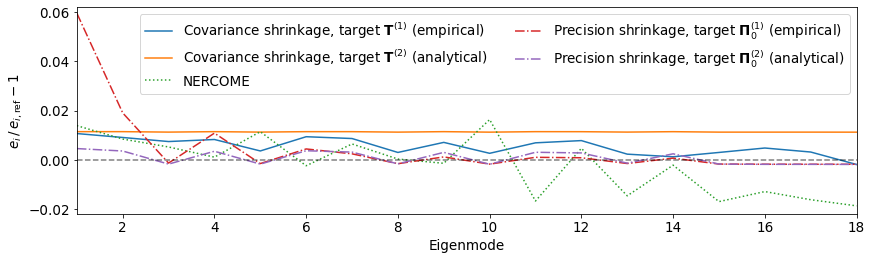

In [159]:
estimates = [
    ["cov", "shrinkage_emp", "Covariance shrinkage, target $\mathbf{T}^{(1)}$ (empirical)"],
    ["cov", "shrinkage_ana", "Covariance shrinkage, target $\mathbf{T}^{(2)}$ (analytical)"],
    ["cov", "NERCOME", "NERCOME"],
    ["pre", "shrinkage_emp", "Precision shrinkage, target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ["pre", "shrinkage_ana", "Precision shrinkage, target $\mathbf{\Pi}_0^{(2)}$ (analytical)"],
]
linestyles = ['-', '-', ':', '-.', '-.']

C_ref = np.loadtxt(os.path.join(mat_path, "n2048/cov_sample/cov_18_18_sample_2048_v1.matrix"))
Psi_ref = np.linalg.inv(C_ref) * hartlap(2048)
evals_ref = np.linalg.eigvalsh(Psi_ref)

emodes = np.linspace(1, 18, 18)

fig, ax = plt.subplots(figsize=(12., 3.5), constrained_layout=True)

for estimate, ls in zip(estimates, linestyles):
    mat_type = estimate[0]
    est_type = estimate[1]
    label = estimate[2]
    
    file_path = os.path.join(mat_path, "n2048", f"{mat_type}_{est_type}", f"{mat_type}_18_18_{est_type}_2048_v1.matrix")
    matrix = np.loadtxt(file_path)
    
    if mat_type == "cov":
        # Obtain precision matrix
        Psi = np.linalg.inv(matrix)
        if est_type == "sample":
            # Apply Hartlap correction
            Psi = Psi*hartlap(n)
    elif mat_type == "pre":
        # The matrix is already the precision matrix
        Psi = matrix
    
    print(mat_type, est_type, np.round(loss(Psi, C_ref), 3))
    
    evals = np.linalg.eigvalsh(Psi)
    ax.plot(emodes, evals/evals_ref - 1, ls=ls, label=label)

ax.axhline(0, ls='--', c='k', alpha=.5)

ax.set_xlim(1., 18.)
ax.set_ylim(-0.022, 0.062)
ax.tick_params(axis='both', which='major', labelsize=13.5)
ax.set_xlabel("Eigenmode", fontsize=13.5)
ax.set_ylabel(r"$e_i \,/\, e_{i,\mathrm{ref}} - 1$", fontsize=13.5)
ax.legend(fontsize=13.5, ncol=2, loc='upper right')

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/eigenspectra_diff_2048.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()